In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [ ]:
%pip install kmodes
%pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

# Unsupervised

In [ ]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

the-movies-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
file_name = "the-movies-dataset.zip"
namelist = []
with ZipFile(file_name,mode = "r") as archive:
  for filename in archive.namelist():
    namelist.append(filename)
print(namelist)

['credits.csv', 'keywords.csv', 'links.csv', 'links_small.csv', 'movies_metadata.csv', 'ratings.csv', 'ratings_small.csv']


In [ ]:
with ZipFile(file_name,mode = "r") as archive:
  archive.extractall()

In [ ]:
ratings = pd.read_csv('ratings_small.csv')
movies = pd.read_csv('movies_metadata.csv')[['id', 'title', 'imdb_id']]
movies.dropna(inplace = True)
movies.loc[:,'id'] = pd.to_numeric(movies['id'])
combine = ratings.merge(movies, how = 'inner', left_on = 'movieId', right_on = 'id')
ratings = combine[['userId', 'movieId', 'rating']]
movies = combine[['id', 'title']]
#x = pd.pivot_table(ratingsample, values = 'rating', index = 'userId', columns = 'movieId')

In [ ]:
m = pd.read_csv('movies_metadata.csv')[['id', 'title', 'imdb_id']]
ratings.movieId.value_counts()

296       324
318       311
593       304
260       291
480       274
         ... 
8831        1
8963        1
127098      1
301         1
129         1
Name: movieId, Length: 2830, dtype: int64

In [ ]:
from pandas.core.groupby.groupby import Series
movie = pd.read_csv('movies_metadata.csv')
print(movie.columns)
new_movie = movie[["title", "runtime", "genres"]]
new_movie.head(15)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


,title,runtime,genres
0,Toy Story,81.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,104.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,101.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,127.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,106.0,"[{'id': 35, 'name': 'Comedy'}]"
5,Heat,170.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam..."
6,Sabrina,127.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '..."
7,Tom and Huck,97.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
8,Sudden Death,106.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
9,GoldenEye,130.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."


In [ ]:
g = movie['genres'].map(eval)
g = pd.json_normalize(g)
f = pd.DataFrame()
for i in range(g.shape[1]):
  a = g[i].dropna().apply(pd.Series)
  f = pd.concat([f,a])
f = f.drop_duplicates().sort_values(by='id').set_index('id')
f.shape

(32, 1)

In [ ]:
# convert first column to id
for i in range(g.shape[1]):
  x = [g[i][j]['id'] if g[i][j] is not None else 0 for j in range(g.shape[0])]
  g[i] = pd.Series(x)

In [ ]:
# select data and preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
newmovie = movie[['title', 'genres', 'runtime']]
dictf = f['name'].to_dict()
# create genre dummies
for y in dictf.keys():
  newmovie[dictf[y]] = newmovie.apply(lambda x: 1 if dictf[y] in x.genres else 0, axis=1)
# drop original genres and rows containing na
newmovie = newmovie.drop(columns = 'genres').dropna()
# don't use title in x
moviex = newmovie.iloc[:, 1:]
# scale runtime
scaler = MinMaxScaler()
moviex['runtime'] = scaler.fit_transform(moviex[['runtime']])

<ipython-input-40-1c95d44d5d82>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newmovie[dictf[y]] = newmovie.apply(lambda x: 1 if dictf[y] in x.genres else 0, axis=1)


## K-ProtoType

In [ ]:
# convert genres back to categorical
#moviex[moviex.columns[1:]] = moviex[moviex.columns[1:]].astype('category')
#from kmodes.kprototypes import KPrototypes
#kproto = KPrototypes(n_clusters=3, init='Cao')
#clusters = kproto.fit_predict(moviex, categorical = list(range(1,33)))

In [ ]:
#from tqdm import tqdm
#import plotly.graph_objects as go
#costs = []
#n_clusters = []
#clusters_assigned = []

#for i in tqdm(range(2, 25)): # Lin: 160,220,10
#    try:
#        kproto = KPrototypes(n_clusters= i, init='Cao')
#        clusters = kproto.fit_predict(moviex, categorical = list(range(1,33)))
#        costs.append(kproto.cost_)
#        n_clusters.append(i)
#        clusters_assigned.append(clusters)
#    except:
#        print(f"Can't cluster with {i} clusters")

#fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
#fig.show()

## K-mean

In [ ]:
# kmean, genres are treated as numerical binary
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#xtrain, xtest, ytrain, ytest = train_test_split(moviex, moviey,random_state=1)
#from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=3, covariance_type='full')
#gmm.fit(newmovie)
#clusrers = gmm.predict(newmovie)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 100)
y = kmeans.fit_predict(moviex)
print(y)

NameError: ignored

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
scores = metrics.silhouette_score(moviex, y, metric='euclidean')
clustered = np.vstack((y,newmovie['title']))
df = pd.DataFrame(clustered.T,columns = ['cluster','name'])
cluster_1 = []
for i in range(len(clustered[0])):
  if clustered[0][i] == 1:
    cluster_1.append(clustered[1][i])
print(cluster_1)
print(len(cluster_1))

['Othello', 'Dead Man Walking', 'Cry, the Beloved Country', 'Georgia', 'The Journey of August King', 'La Haine', "Margaret's Museum", 'The Boys of St. Vincent', 'The Silences of the Palace', 'The Neon Bible', 'Virgin Mary', 'Apollo 13', 'Safe', 'Showgirls', 'The Stars Fell on Henrietta', "White Man's Burden", 'The Browning Version', 'Burnt by the Sun', 'Ladybird Ladybird', 'Losing Isaiah', 'Once Were Warriors', 'Panther', 'Red Firecracker, Green Firecracker', 'The War', 'Cobb', 'Mrs. Parker and the Vicious Circle', 'Reality Bites', 'Safe Passage', 'Boys Life: Three Stories of Love, Lust, and Liberation', 'Colonel Chabert', 'Blue Chips', 'Dangerous Game', 'Farewell My Concubine', 'Fearless', 'In the Name of the Father', 'King of the Hill', 'The Man without a Face', 'Philadelphia', 'The Program', 'Rudy', 'The Saint of Fort Washington', 'Savage Nights', 'Searching for Bobby Fischer', 'Second Best', 'The Slingshot', 'My Favorite Season', "My Mother's Courage", 'Pather Panchali', 'The World

In [ ]:
score = []
for i in range(10,300,15):
  kmeans = KMeans(n_clusters = i)
  y = kmeans.fit_predict(moviex)
  scores = metrics.silhouette_score(moviex, y, metric='euclidean')
  score.append(scores)
plt.plot(range(10,300,15), score, 'o-')
plt.xlabel('number of cluster')
plt.ylabel('Sil_coe')
plt.title('K-means')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
clustered = np.vstack((y,newmovie['title']))
df = pd.DataFrame(clustered.T,columns = ['cluster','name'])
cluster_5 = []
x = []

for j in range(1,301):
  cluster_5 = []
  for i in range(len(clustered[0])):
    if clustered[0][i] == j:
      cluster_5.append(clustered[1][i])
  x.append(len(cluster_5))
plt.plot(range(1,301), x)
plt.title('number of movies in each cluster')
plt.show()
#print(cluster_5)
#print(len(cluster_5))
#print(len(clustered[0]))
print(sorted(x))

## Hierarchical

In [ ]:
import time as time
import mpl_toolkits.mplot3d

import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
print("Compute unstructured hierarchical clustering...")
connectivity = kneighbors_graph(moviex, n_neighbors=10, include_self=False)
ward = AgglomerativeClustering(n_clusters=30,connectivity=connectivity,linkage="ward").fit(moviex)
label = ward.labels_
print(f"Number of points: {label.size}")

In [ ]:
clustered = np.vstack((label,newmovie['title']))
df = pd.DataFrame(clustered.T,columns = ['cluster','name'])
print(df.head(100))

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
X, y = datasets.load_iris(return_X_y=True)

In [ ]:
cluster_1 = []
for i in range(len(clustered[0])):
  if clustered[0][i] == 1:
    cluster_1.append(clustered[1][i])
print(cluster_1)
print(len(cluster_1))

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

ward = AgglomerativeClustering(n_clusters=None,connectivity=connectivity,linkage="ward",distance_threshold=0).fit(moviex)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ward, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ward, truncate_mode="level", p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.figure(figsize=(500,1))
plt.show()
ward.labels_

In [ ]:
connectivity = kneighbors_graph(moviex, n_neighbors=10, include_self=False)
ward = AgglomerativeClustering(n_clusters=200,connectivity=connectivity,linkage="ward").fit(moviex)
label = ward.labels_
print(f"Number of points: {label.size}")
clustered = np.vstack((label,newmovie['title']))
df = pd.DataFrame(clustered.T,columns = ['cluster','name'])
cluster_1 = []
for i in range(len(clustered[0])):
  if clustered[0][i] == 1:
    cluster_1.append(clustered[1][i])
print(cluster_1)
print(len(cluster_1))

In [ ]:
score = []
for i in range(10,200,10):
  ward = AgglomerativeClustering(n_clusters=i,connectivity=connectivity,linkage="ward").fit(moviex)
  label = ward.labels_
  scores = metrics.silhouette_score(moviex, label, metric='euclidean')
  score.append(scores)
plt.plot(range(10,200,10), score, 'o-')
plt.xlabel('number of cluster')
plt.ylabel('Sil_coe')
plt.title('Elbow Method')
plt.show()

In [ ]:
score = []
for i in range(10,200,10):
  ward = AgglomerativeClustering(n_clusters=i,connectivity=connectivity,linkage="complete").fit(moviex)
  label = ward.labels_
  scores = metrics.silhouette_score(moviex, label, metric='euclidean')
  score.append(scores)
plt.plot(range(10,200,10), score, 'o-')
plt.xlabel('number of cluster')
plt.ylabel('Sil_coe')
plt.title('Elbow Method')
plt.show()

In [ ]:
score = []
for i in range(10,200,10):
  ward = AgglomerativeClustering(n_clusters=i,connectivity=connectivity,linkage="average").fit(moviex)
  label = ward.labels_
  scores = metrics.silhouette_score(moviex, label, metric='euclidean')
  score.append(scores)
plt.plot(range(10,200,10), score, 'o-')
plt.xlabel('number of cluster')
plt.ylabel('Sil_coe')
plt.title('Elbow Method')
plt.show()

In [ ]:
ward = AgglomerativeClustering(n_clusters=200,connectivity=connectivity,linkage="ward").fit(moviex)
label = ward.labels_

x = []

for j in range(1,201):
  cluster_5 = []
  for i in range(len(label)):
    if label[i] == j:
      cluster_5.append(label[i])
  x.append(len(cluster_5))
plt.plot(range(1,201), x)
plt.title('number of movies in each cluster')
plt.show()

In [ ]:
print(sorted(x))
for i in range(len(x)):
    if x[i] == 3559:
      print(i)

clustered = np.vstack((label,newmovie['title']))
df = pd.DataFrame(clustered.T,columns = ['cluster','name'])
cluster_1 = []
for i in range(len(clustered[0])):
  if clustered[0][i] == 181:
    cluster_1.append(clustered[1][i])
print(cluster_1)
print(len(cluster_1))

## DB-SCAN

In [ ]:
#Python Example for selecting Epsilon (ε)
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

#Calculate the average distance between each point in the movie set and its 66 nearest neighbors .
neighbors = NearestNeighbors(n_neighbors=66)
neighbors_fit = neighbors.fit(moviex)
distances, indices = neighbors_fit.kneighbors(moviex)

#Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

#The ideal value for ε will be equal to the distance value at the point of maximum curvature

In [ ]:
#DNSCAN technique ~ computation
# adjust epsilon if needed
from sklearn.cluster import DBSCAN
db = DBSCAN(eps= 0.05, min_samples=66)
clustering_labels = db.fit_predict(moviex)
n_clusters_ = len(set(clustering_labels)) - (1 if -1 in clustering_labels else 0)
n_noise_ = list(clustering_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

#Evaluate the DBSCAN technique
from sklearn import metrics

moviexz = moviex.copy()
moviexz['labels'] = clustering_labels
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(moviexz, moviexz['labels']))


# Supervised

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"
!kaggle datasets download -d ebiswas/imdb-review-dataset

imdb-review-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
file_name = "imdb-review-dataset.zip"
from zipfile import ZipFile
namelist = []
with ZipFile(file_name,mode = "r") as archive:
  for filename in archive.namelist():
    namelist.append(filename)
print(namelist)

['part-01.json', 'part-02.json', 'part-03.json', 'part-04.json', 'part-05.json', 'part-06.json', 'sample.json']


In [ ]:
import json
import csv
import io
with ZipFile(file_name,mode = "r") as archive:
  archive.extractall()


In [ ]:
f = open('sample.json')
json_file = json.load(f)
length = len(json_file)
print(length)
id_list = {}
for i in range(length):
  if json_file[i]["reviewer"] not in id_list:
    id_list[json_file[i]["reviewer"]] = 1
  else:
    id_list[json_file[i]["reviewer"]] += 1
for element in list(id_list):
  if id_list[element] < 10:
    id_list.pop(element)
print(id_list)
print(len(id_list))


100000
{'OriginalMovieBuff21': 27, 'Aaron1375': 31, 'diand_': 57, 'lost-in-limbo': 65, 'NateManD': 50, 'Barky44': 21, 'theowinthrop': 225, 'chuckc': 10, 'CAMACHO-4': 24, 'TxMike': 120, 'aliasanythingyouwant': 44, 'bensonmum2': 137, 'cshep': 13, 'moviemanMA': 46, 'lee_eisenberg': 542, 'Son_of_Mansfield': 22, 'Nazi_Fighter_David': 93, 'pocca': 18, 'lemon_magic': 84, 'tarbosh22000': 31, 'sol-': 237, 'HumanoidOfFlesh': 62, 'yonhope': 19, 'ma-cortes': 86, 'MartinHafer': 316, 'Quinoa1984': 169, 'Jordan_Haelend': 10, 'metalrox_2000': 19, 'Chip_douglas': 64, 'SeminolePhenom': 104, 'Quicksand': 11, 'Movie Nuttball': 130, 'manuel-pestalozzi': 17, 'grahamclarke': 19, 'bkoganbing': 356, 'Coventry': 212, 'Boba_Fett1138': 186, 'sol1218': 93, 'mstomaso': 28, 'Smells_Like_Cheese': 110, 'worship_HIM97': 14, 'TOMNEL': 66, 'sol-kay': 86, 'slymusic': 44, 'rparham': 17, 'dunmore_ego': 47, 'poolandrews': 226, 'CSM126-1': 17, 'udar55': 28, 'aparna-1': 11, 'Spuzzlightyear': 192, 'junk-monkey': 18, 'Captain_Co

In [ ]:
import matplotlib.pylab as plt

dict(sorted(id_list.items(), key=lambda item: item[1]))
names = list(id_list.keys())
values = list(id_list.values())

fig, ax = plt.subplots(figsize = (800, 30))
ax.bar(names, values)
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
plt.show()

In [ ]:
sample = pd.read_json('sample.json')
sample.groupby('movie')['review_id'].count().sort_values()

movie
Moveable Feast (1996)                                                       1
Police Tactics (1974)                                                       1
Police Quest: In Pursuit of the Death Angel (1987 Video Game)               1
Police Chasing Scorching Auto (1906)                                        1
Police Academy 6: City Under Siege (1989)                                   1
                                                                         ... 
The Chronicles of Narnia: The Lion, the Witch and the Wardrobe (2005)     650
Charlie and the Chocolate Factory (2005)                                  651
Serenity (2005)                                                           971
King Kong (2005)                                                         1043
Harry Potter and the Goblet of Fire (2005)                               1285
Name: review_id, Length: 29192, dtype: int64

## Linear Regression

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
# read files
movies = pd.read_csv('movies_metadata.csv')[["id","runtime", "genres",'adult','budget','revenue']]
movies = movies[(movies[['budget']] != 0).all(axis=1)]
movies = movies[(movies[['revenue']] != 0).all(axis=1)]
movies.dropna(inplace =True)
movies.loc[:, 'id'] = pd.to_numeric(movies['id'])

ratings = pd.read_csv('ratings.csv')
ratings = ratings.groupby('userId').filter(lambda x: len(x) >= 50)
ratings = ratings.drop(columns='timestamp')
new_movies = movies[movies['id'].isin(ratings['movieId'])]
new_movies = new_movies.rename(columns={"id": "movieId"})

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyboardInterrupt: ignored

In [ ]:
# convert genres to dummy
g = new_movies['genres'].map(eval)
g = pd.json_normalize(g)
f = pd.DataFrame()
for i in range(g.shape[1]):
  a = g[i].dropna().apply(pd.Series)
  f = pd.concat([f,a])
f = f.drop_duplicates().sort_values(by='id').set_index('id')

for i in range(g.shape[1]):
  x = [g[i][j]['id'] if g[i][j] is not None else 0 for j in range(g.shape[0])]
  g[i] = pd.Series(x)

from sklearn.preprocessing import MinMaxScaler
dictf = f['name'].to_dict()
# create genre dummies
for y in dictf.keys():
  new_movies[dictf[y]] = new_movies.apply(lambda x: 1 if dictf[y] in x.genres else 0, axis=1)
# drop original genres and rows containing na
moviex = new_movies.drop(columns = 'genres').dropna()
# scale runtime
scaler = MinMaxScaler()
moviex['runtime'] = scaler.fit_transform(moviex[['runtime']])


In [ ]:
# merge two ratings and movies
movie_rates = ratings.merge(moviex, how='inner', on=['movieId'])
movie_rates['budget'] = movie_rates['budget'].astype(str).astype(float)
df_dummies = pd.get_dummies(movie_rates, prefix='', prefix_sep='', columns=['adult'])
df_dummies

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
dummy_sample = df_dummies.sample(frac = 0.1, random_state = 123)
dummy_sample.dropna

In [ ]:
y = dummy_sample['rating']
X = dummy_sample[['runtime', 'budget', 'revenue',
       'Adventure', 'Fantasy', 'Animation', 'Drama', 'Horror', 'Action',
       'Comedy', 'History', 'Western', 'Thriller', 'Crime', 'Documentary',
       'Science Fiction', 'Mystery', 'Music', 'Romance', 'Family', 'War',
       'Foreign']]

In [ ]:
# split train and test test
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,train_size=0.8,random_state=123)

In [ ]:
# train
model_lr = linear_model.LinearRegression()
model_lr.fit(Xtrain, ytrain)
Y_pred_train = model_lr.predict(Xtrain)
print('Coefficients:', model_lr.coef_)
print('Intercept:', model_lr.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(ytrain, Y_pred_train))
print('Coefficient of determination (R^2): %.2f' % r2_score(ytrain, Y_pred_train))

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ytrain, Y_pred_train)
rmse = np.sqrt(mean_squared_error(ytrain, Y_pred_train))

In [ ]:
# test
Y_pred_test = model_lr.predict(Xtest)
print('Coefficients:', model_lr.coef_)
print('Intercept:', model_lr.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(ytest, Y_pred_test))
print('Coefficient of determination (R^2): %.2f' % r2_score(ytest, Y_pred_test))

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ytrain, Y_pred_train)
rmse = np.sqrt(mean_squared_error(ytest, Y_pred_test))

In [ ]:
# get top 10 features
feature_list = np.array(model_lr.feature_names_in_)
coeff = np.array(model_lr.coef_)
df = pd.DataFrame({'Features Name':feature_list, 'Coefficients':coeff})
df_lr = pd.DataFrame(df, columns=['Features Name', 'Coefficients'])
sorted_coeff = df_lr.sort_values(by=['Coefficients'], ascending=False)
sorted_coeff[:10]['Features Name'].to_list()

In [ ]:
# correlation matrix
corr_ViolationCounty = dummy_sample.corr()
plt.figure(figsize=(30, 20))
heatmap_ViolationCounty  = sns.heatmap(corr_ViolationCounty, vmin=-1, vmax=1, annot=True)
heatmap_ViolationCounty.set_title('Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.replace(np.nan,0)
ratings = ratings.fillna(0)
ratings = ratings.groupby(['userId']).filter(lambda x: len(x)>=2000)

In [ ]:
split_value = int(len(ratings) * 0.80)
train_data = ratings[:split_value]
test_data = ratings[split_value:]

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

## SVD/ SVD++/ KNN Baseline

In [ ]:
# reload the movies data
ratings = pd.read_csv('ratings_small.csv')
movies = pd.read_csv('movies_metadata.csv')[['id', 'title', 'imdb_id']]
movies.dropna(inplace = True)
movies.loc[:,'id'] = pd.to_numeric(movies['id'])
combine = ratings.merge(movies, how = 'inner', left_on = 'movieId', right_on = 'id')
ratings = combine[['userId', 'movieId', 'rating']]
movies = combine[['id', 'title']]
#x = pd.pivot_table(ratingsample, values = 'rating', index = 'userId', columns = 'movieId')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Simple SVD recommender
import math
from typing import Tuple, List


class SVDRecommender(object):
    def __init__(self) -> None:
        """
        Initialize with ImgCompression object for SVD purposes
        """
        #self.imgcompression = ImgCompression()


    def create_movie_dict(self, movies_df):
        """
        PROVIDED TO STUDENTS:
        Load movie data and create mappings from movie name to movie ID and vice versa
        """
        #movies_df = pd.read_csv(movie)[['id', 'title']]
        self.movie_names_dict = dict(zip(movies_df.id, movies_df.title))
        self.movie_id_dict = dict(zip(movies_df.title, movies_df.id))

    def load_ratings_datasets(
        self, ratings_df
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        PROVIDED TO STUDENTS: Load train and test user-movie ratings datasets
        """
        train = ratings_df.sample(frac = 0.8, random_state = 10086)
        test = ratings_df.drop(train.index)
        return train, test

    def get_movie_name_by_id(self, movie_id: int) -> str:
        """
        PROVIDED TO STUDENTS: Get movie name for corresponding movie id
        """
        return self.movie_names_dict[movie_id]

    def get_movie_id_by_name(self, movie_name: str) -> int:
        """
        PROVIDED TO STUDENTS: Get movie id for corresponding movie name
        """
        return self.movie_id_dict[movie_name]

    def recommender_svd(
        self, k: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Given the matrix of Ratings (R) and number of features k,  return the matrices
        U_k and V_k by using svd and compress methods that you have already implemented
        in imgcompression.py.
        Args:
            R: (NxM) numpy array the train dataset upon which we'll try to predict / fill in missing predictions
            k: (int) number of important features we would like to use for our prediction

        Return:
            U_k: (Nxk) array containing k features for each user
            V_k: (kXM) array containing k features for each movie
        """
        if len(self.R.shape) == 2:
            U, S, V = np.linalg.svd(self.R)
            U_k, S_k, V_k = U[:,:k], S[:k], V[:k,:]
        else:
            U = np.empty((self.R.shape[0],self.R.shape[0], 3))
            S = np.empty((min(self.R.shape[0],self.R.shape[1]), 3))
            V = np.empty((self.R.shape[1],self.R.shape[1], 3))
            for i in range(3):
                r = np.linalg.svd(self.R[:,:,i])
                U[:,:,i] = r[0]
                S[:, i] = r[1]
                V[:,:, i] = r[2]
            U_k, S_k, V_k = U[:,:k,:], S[:k], V[:k, :, :]
        self.U_k, self.V_k = U_k @ np.sqrt(np.diag(S_k)), np.sqrt(np.diag(S_k)) @ V_k
        return self.U_k, self.V_k

    def process_R(self):
        mask = np.isnan(self.R)
        masked_array = np.ma.masked_array(self.R, mask)
        r_means = np.array(np.mean(masked_array, axis=0))
        R_filled = masked_array.filled(r_means)
        R_filled = R_filled - r_means
        self.R = R_filled
        self.r_means = r_means

    def predict(
        self,
        #R: np.ndarray,
        #U_k: np.ndarray,
        #V_k: np.ndarray,
        #users_index: dict,
        #movies_index: dict,
        k,
        user_id: int,
        top_n,
    ) -> List[str]:
        """
        Given a user specified by `user_id`, recommend the `top_k` movies that the user would want to watch among a list of movies in `movies_pool`.
        Use the compressed SVD user matrix `U_k` and movie matrix `V_k` in your prediction.

        Args:
            R: (NxM) numpy array the train dataset containing only the given user-movie ratings
            U_k: (Nxk) array containing k features for each user
            V_k: (kXM) array containing k features for each movie
            users_index: (N,) dictionary containing a mapping from actual `userId` to the index of the user in R (or) U_k
            movies_index: (M,) dictionary containing a mapping from actual `movieId` to the movie of the user in R (or) V_k
            user_id: (str) the user we want to recommend movies for
            movies_pool: List(str) numpy array of movie_names from which we want to select the `top_n` recommended movies
            top_n: (int) number of movies to recommend

        Return:
            recommendation: List(str) list of movies the user with user_id would be
                            most interested in watching next and hasn't watched yet.
                            Must be a subset of `movies_pool`

        Hints:
            1. You can use R to filter out movies already watched (or rated) by the user
            2. Utilize method `get_movie_id_by_name()` defined above to convert movie names to Id
            3. Utilize dictionaries `users_index` and `movies_index` to map between userId, movieId to their
                corresponding indices in R (or U_k, V_k)
        """
        self.process_R()
        self.recommender_svd(k)
        rec = {}
        user = self.users_index[user_id]
        nw = np.isnan(self.R[user, :])
        nwatch = np.array(range(self.R.shape[1]))[nw]
        ratings = self.U_k[user] @ self.V_k
        rank = ratings.argsort()[::-1]
        mid = [list(self.movies_index.keys())[list(self.movies_index.values()).index(x)] for x in rank]
        for i in range(top_n):
            rec[self.get_movie_name_by_id(mid[rank[i]])] = ratings[rank[i]]
        return rec

    def create_ratings_matrix(
        self, ratings_df: pd.DataFrame
    ) -> Tuple[np.ndarray, dict, dict]:
        """
        FUNCTION PROVIDED TO STUDENTS

        Given the pandas dataframe of ratings for every user-movie pair,
        this method returns the data in the form a N*M matrix where,
        M[i][j] is the rating provided by user:(i) for movie:(j).

        Args:
            ratings_df: (pd.DataFrame) containing (userId, movieId, rating)
        """
        userList = ratings_df.iloc[:, 0].tolist()
        movieList = ratings_df.iloc[:, 1].tolist()
        ratingList = ratings_df.iloc[:, 2].tolist()

        users = list(set(ratings_df.iloc[:, 0]))
        movies = list(set(ratings_df.iloc[:, 1]))

        users_index = {users[i]: i for i in range(len(users))}
        pd_dict = {movie: [np.nan for i in range(len(users))] for movie in movies}
        for i in range(0, len(ratings_df)):
            movie = movieList[i]
            user = userList[i]
            rating = ratingList[i]
            pd_dict[movie][users_index[user]] = rating

        X = pd.DataFrame(pd_dict)
        X.index = users

        itemcols = list(X.columns)
        movies_index = {itemcols[i]: i for i in range(len(itemcols))}
        self.R, self.users_index, self.movies_index = np.array(X), users_index, movies_index
        return np.array(X), users_index, movies_index


In [ ]:
recommender = SVDRecommender()
recommender.create_movie_dict(movies)
train, test = recommender.load_ratings_datasets(ratings)
R, users_index, movies_index = recommender.create_ratings_matrix(train)
recommender.predict(10, 100, 10)

{"It's Hard Being Loved by Jerks": 0.030320679305511355,
 'Vertigo': 0.022368694645680868,
 "Everybody's Fine": 0.02008463072516797,
 'Very Annie Mary': 0.019690098332238122,
 'Notorious': 0.019262850482952964,
 'Nashville': 0.018095321056034844,
 'My Life Without Me': 0.01772839074371968,
 'The Last Hurrah': 0.017555307164473847,
 'The Gendarme in New York': 0.017294320952437926,
 'Many Rivers to Cross': 0.017240694194985307}

In [ ]:
from sklearn.metrics import mean_squared_error
# Implement the method `recommender_svd` and run it for the following values of features
no_of_features = [2, 3, 8, 15, 18, 25, 30]
test_errors = []

for k in no_of_features:
    U_k, V_k = recommender.recommender_svd(k)
    pred = [] # to store the predicted ratings
    for _, row in test.iterrows():
        user = row['userId']
        movie = row['movieId']
        u_index = recommender.users_index[user]
        # If we have a prediction for this movie, use that
        if movie in recommender.movies_index:
            m_index = recommender.movies_index[movie]
            pred_rating = np.dot(U_k[u_index, :], V_k[:,m_index]) + recommender.r_means[m_index]
        # Else, use an average of the users ratings
        else:
            pred_rating = np.mean(np.dot(U_k[u_index], V_k)) + recommender.r_means[m_index]
        pred.append(pred_rating)
    test_error = mean_squared_error(test['rating'], pred, squared = False)
    test_errors.append(test_error)
    print("RMSE for k = {} --> {}".format(k, test_error))

RMSE for k = 2 --> 0.9634214264762256
RMSE for k = 3 --> 0.9641943934967319
RMSE for k = 8 --> 0.9616062677255452
RMSE for k = 15 --> 0.9612878297081773
RMSE for k = 18 --> 0.96255169044792
RMSE for k = 25 --> 0.9667913649332958
RMSE for k = 30 --> 0.9676292443555781


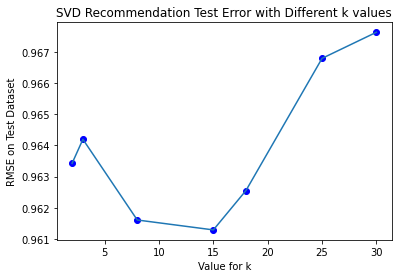

In [ ]:
fig = plt.figure()
plt.plot(no_of_features, test_errors, 'bo')
plt.plot(no_of_features, test_errors)
plt.xlabel("Value for k")
plt.ylabel("RMSE on Test Dataset")
plt.title("SVD Recommendation Test Error with Different k values")

if not 1:
    fig.text(0.5, 0.5, EO_TEXT, transform=fig.transFigure,
        fontsize=EO_SIZE/2, color=EO_COLOR, alpha=EO_ALPHA*0.5, fontname=EO_FONT,
        ha='center', va='center', rotation=EO_ROT)

In [ ]:
# try surprise package
from sklearn.model_selection import RandomizedSearchCV
from surprise import Reader, SVD, SVDpp, NMF, KNNBaseline, accuracy, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV


# when importing from a DF, you only need to specify the scale of the ratings.
reader = Reader(rating_scale=(1,5))
#into surprise:
fulldata = Dataset.load_from_df(ratings,reader)
traindata = Dataset.load_from_df(train,reader)
testdata = Dataset.load_from_df(test,reader)

In [ ]:
# SVD with sgd, sue gridsearch to tune parameters, use a range with default as mean and 80% left and right and step of 20%.
param_grid = {'n_factors': np.arange(20, 60, 20), 'biased': [True, False], 'n_epochs': np.arange(10, 30, 10), 'lr_all': np.arange(0.001, 0.003, 0.001).tolist(), 'reg_all': np.arange(0.004, 0.012, 0.004), 'random_state': [10086]}
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 10)

gs.fit(traindata)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.9070160980329893
{'n_factors': 20, 'biased': True, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.008, 'random_state': 10086}


In [ ]:
svdbest = gs.best_estimator['rmse']
cross_validate(svdbest, testdata, measures=['RMSE'], cv = 10, verbose = True)

In [ ]:
# SVDpp with sgd, use gridsearch to tune parameters, use a range with default as mean and 80% left and right and step of 20%.
param_grid = {'n_factors': np.arange(4, 36, 4), 'n_epochs': np.arange(10, 100, 10), 'lr_all': np.arange(0.001, 0.009, 0.001).tolist(), 'reg_all': np.arange(0.004, 0.036, 0.004), 'random_state': [10086]}
svdppgs = GridSearchCV(SVDpp, param_grid, measures = ['rmse'], cv = 10)

svdppgs.fit(traindata)

# best RMSE score
print(svdppgs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(svdppgs.best_params["rmse"])

In [ ]:
svdppbest = svdppgs.best_estimator['rmse']
cross_validate(svdppbest, testdata, measures=['RMSE'], cv = 10, verbose = True)

In [ ]:
# KNNBaseline, use gridsearch to tune parameters, use a range with default as mean and 80% left and right and step of 20%.
param_grid = {
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg': [1, 2],
    },
    'k': np.arange(8, 32, 8),
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [1, 5],
        'user_based': [False],
    },
}
knnbgs = GridSearchCV(KNNBaseline, param_grid, measures = ['rmse'], cv = 10)
knnbgs.fit(traindata)

# best RMSE score
print(knnbgs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(knnbgs.best_params["rmse"])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [ ]:
knnbbest = knnbgs.best_estimator['rmse']
cross_validate(knnbbest, testdata, measures=['RMSE'], cv = 10, verbose = True)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

{'test_rmse': array([0.96152821, 1.00552909, 0.98362667, 1.00476523, 0.97106178,
        0.9855344 , 1.00454062, 1.00938047, 1.01263376, 1.02323506]),
 'fit_time': (0.04641461372375488,
  0.04503035545349121,
  0.059258222579956055,
  0.045148372650146484,
  0.04961276054382324,
  0.04581499099731445,
  0.04974508285522461,
  0.05550694465637207,
  0.054877519607543945,
  0.05698037147521973),
 'test_time': (0.047859907150268555,
  0.04904937744140625,
  0.05279207229614258,
  0.0530240535736084,
  0.4053502082824707,
  0.04520893096923828,
  0.045178890228271484,
  0.04906415939331055,
  0.05384325981140137,
  0.04625725746154785)}

In [ ]:
# get the top n recommendation for all or specific users
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """


    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))


    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# try top_n with svdbest
fulltrain = fulldata.build_full_trainset()
svdbest.fit(fulltrain)

# predict ratings for all pairs (u, i) that are NOT in the training set.
predictions_svd = svdbest.test(fulltrain.build_anti_testset())

top_n_svd = get_top_n(predictions_svd, n = 10)

# print recommended movie id for users
for uid, user_ratings in top_n_svd.items():
    print(uid, [iid for (iid, _) in user_ratings])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
1 [98491, 72356, 6163, 59392, 42191, 93061, 25763, 47518, 4789, 80]
4 [527, 318, 778, 2959, 1247, 5995, 33166, 111, 1250, 2019]
7 [91690, 108548, 858, 107412, 86817, 912, 54734, 107081, 296, 527]
19 [899, 4226, 2692, 922, 3683, 6016, 926, 4973, 5995, 2064]
21 [318, 8982, 6016, 608, 745, 3007, 2064, 4226, 926, 111]
22 [318, 114, 582, 8765, 953, 913, 898, 68954, 899, 2692]
41 [318, 858, 6016, 1260, 922, 3035, 527, 913, 905, 2019]
78 [905, 559, 681, 690, 793, 820, 854, 913, 194, 3037]
118 [858, 318, 86817, 3580, 54734, 1450, 1563, 1819, 4930, 73290]
130 [5995, 968, 58559, 296, 1089, 922, 926, 913, 905, 898]
150 [2636, 2649, 2652, 527, 91690, 5422, 6016, 74727, 747, 953]
202 [2652, 2636, 2649, 2637, 61361, 858, 1252, 1945, 608, 899]
207 [1444, 1450, 1563, 1819, 4930, 26509, 7459, 845, 74727, 90061]
217 [318, 4252, 26599, 91673, 845, 70121, 4375, 1450, 1563, 1819]
232 [6016, 111913, 2692,

In [ ]:
# try top 10 movies for user 75 using svd
top_n_svd[75]

[(8899, 4.268735472817196),
 (698, 4.119648243359524),
 (162, 4.102301321840008),
 (968, 4.085052772848579),
 (905, 4.0468634340109135),
 (913, 4.044387599957499),
 (608, 4.042190436371602),
 (926, 4.0401977182644515),
 (750, 4.0393634231410624),
 (3683, 4.01516158610878)]

In [ ]:
# find movie names and ratings for corresponding ids for user 75
def top_n_name_and_rating(top):
  u_movies = movies.drop_duplicates(subset = 'id')
  for iid, rating in top:
    print(u_movies.loc[u_movies['id'] == iid, 'title'].values[0], rating)

top_n_name_and_rating(top_n_svd[75])

In [ ]:
# try top_n with svdppbest
fulltrain = fulldata.build_full_trainset()
svdppbest.fit(fulltrain)

# predict ratings for all pairs (u, i) that are NOT in the training set.
predictions_svdpp = svdppbest.test(fulltrain.build_anti_testset())

top_n_svdpp = get_top_n(predictions_svdpp, n = 10)
top_n_name_and_rating(top_n_svdpp[75])

In [ ]:
# try top_n with knnbbest
fulltrain = fulldata.build_full_trainset()
knnbbest.fit(fulltrain)

# predict ratings for all pairs (u, i) that are NOT in the training set.
predictions_knnb = knnbbest.test(fulltrain.build_anti_testset())

top_n_knnb = get_top_n(predictions_knnb, n = 10)
top_n_name_and_rating(top_n_knnb[75])

In [ ]:
# find cluster with the highest average ratings, use hierarchical clustering
# first load the data again to make it clear
newmovie = movie[['title', 'id', 'genres', 'runtime']]
dictf = f['name'].to_dict()
# create genre dummies
for y in dictf.keys():
  newmovie[dictf[y]] = newmovie.apply(lambda x: 1 if dictf[y] in x.genres else 0, axis=1)
# drop original genres and rows containing na and convert id to int
newmovie = newmovie.drop(columns = 'genres').dropna()
newmovie.loc[:,'id'] = pd.to_numeric(newmovie['id'])
# scale runtime
scaler = MinMaxScaler()
newmovie['runtime'] = scaler.fit_transform(newmovie[['runtime']])

# make moviex align with svd dataset
moviex = newmovie[newmovie['id'].isin(movies['id'])]
# dont use id and title in x
moviexx = moviex.iloc[:, 2:]

connectivity = kneighbors_graph(moviexx, n_neighbors=10, include_self=False)
ward = AgglomerativeClustering(n_clusters=175,connectivity=connectivity,linkage="ward").fit(moviexx)
label = ward.labels_
moviex['cluster'] = label
# these movie ids are in movies but not moviex, remove to prevent error
p = [63276, 63179, 61361]
movies['cluster'] = [moviex.loc[moviex['id'] == x, 'cluster'].values[0] if x not in p else -1 for x in movies['id']]

def find_highest_cluster(uid, predictions):
  allratings = get_top_n(predictions, n = len(moviex))[uid]
  df = pd.DataFrame(allratings, columns =['iid', 'rating'])
  # ignore ids in p here as well
  df['cluster'] = [moviex.loc[moviex['id'] == x, 'cluster'].values[0] if x not in p else -1 for x in df['iid']]
  meanrating = df.groupby('cluster')['rating'].mean().sort_values(ascending = False)
  return {meanrating.index[0]: meanrating.iloc[0]}

# find highest cluster with svd
find_highest_cluster(75, predictions_svd)

In [ ]:
# find highest cluster with svdpp
find_highest_cluster(75, predictions_svdpp)

In [ ]:
# find highest cluster with knnb
find_highest_cluster(75, predictions_knnb)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile

def model(df, modeldict_NB, peformance_dict_NB, RMSE_NB):
  y = df['rating']
  y = y*2
  X = df.drop(columns = {'userId', 'movieId', 'rating'}).astype('int')
  y = y.astype('int')
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


  model = GaussianNB()
  fitG = model.fit(X_train, Y_train)
  score = fitG.score(X_test, Y_test)
  predicted = model.predict(X_test)

  # modeldict_NB.append(fitG)
  peformance_dict_NB.append(score)
  RMSE_NB.append(mean_squared_error(Y_test, predicted)**(1/2.0))

  return (modeldict_NB, peformance_dict_NB,RMSE_NB)

modeldict_NB = []
peformance_dict_NB = []
RMSE_NB = []
dicts = mov_ratings.groupby(['userId']).apply(model, modeldict_NB,peformance_dict_NB,RMSE_NB)

In [ ]:
items = 0
for item in peformance_dict_NB:
  items += item
items/len(peformance_dict_NB)

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import numpy as np

def model(df, modeldict_NB, peformance_dict_NB, RMSE_NB,len_x):
  y = df['rating']
  y = y*2
  X = df.drop(columns = {'userId', 'movieId', 'rating'}).astype('int')
  y = y.astype('int')
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  len_x2 = len(X)
  model = BernoulliNB()
  fitB = model.fit(X_train, Y_train)
  score = fitB.score(X_test, Y_test)
  predicted = model.predict(X_test)

  modeldict_NBm.append(fitB)
  peformance_dict_NBm.append(score)
  RMSE_NBm.append(mean_squared_error(Y_test, predicted)**(1/2.0))
  len_x.append(len_x2)
  return (modeldict_NB, peformance_dict_NB,RMSE_NB)

modeldict_NBm = []
peformance_dict_NBm = []
RMSE_NBm = []
len_x = []
dicts = mov_ratings.groupby(['userId']).apply(model, modeldict_NBm,peformance_dict_NBm,RMSE_NBm,len_x)

In [ ]:
mov_ratings.head(40)

In [ ]:
X = mov_ratings.loc[mov_ratings['userId'] == 279  ]
y2 = mov_ratings.loc[mov_ratings['userId'] == 279   ]
y2 = y2*2
X = X.drop(columns = {'userId', 'movieId', 'rating'}).astype('int')
y2 = y2['rating'].astype('int')

X_train, X_test, Y_train, Y_test = train_test_split(X, y2, test_size = 0.2, random_state = 2)
len_x2 = len(X)
model = BernoulliNB()
fitB = model.fit(X_train, Y_train)
score = fitB.score(X_test, Y_test)
predicted = model.predict(X_test)
print(score)
print(list(predicted))
print(Y_test.tolist())
print(len(predicted))
len(Y_test)

In [ ]:
tuple(mov_ratings.groupby('userId').size().agg(['idxmax','max']))

In [ ]:
items = 0
for item in peformance_dict_NBm:
  items += item
items/len(peformance_dict_NBm)

In [ ]:
# weighted
sum = 0
for i in range(len(peformance_dict_NBm)):
  sum += peformance_dict_NBm[i]*len_x[i]
sum/len(mov_ratings)

In [ ]:
sum(RMSE_NBm)/len(RMSE_NBm)

In [ ]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):

    X = mov_ratings[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


# features to consider removing
considered_features = ['runtime', 'budget', 'revenue']

# compute vif
compute_vif(considered_features).sort_values('VIF', ascending=False)

In [ ]:
#user specific

In [ ]:
userlist = {}
for item in MartinHafer:
  for i in range(len(item)):
    if '(' == item[i]:
      newitem = item[:i-1]
      if newitem[-1] == ' ':
        newitem = newitem[:-1]
      userlist[newitem] = MartinHafer[item]




In [ ]:
userlist2 = {}
for item in TheLittleSongbird:
  for i in range(len(item)):
    if '(' == item[i]:
      newitem = item[:i-1]
      if newitem[-1] == ' ':
        newitem = newitem[:-1]
      userlist2[newitem] = TheLittleSongbird[item]

In [ ]:
count = 0
confirmedlist = {}
for item in userlist:
  if item in movienamelist:
    confirmedlist[item] = int(userlist[item])
    count += 1
  #else:
    #print('not in:' ,item)
print(count)

8014


In [ ]:
count = 0
confirmedlist2 = {}
for item in userlist2:
  if item in movienamelist:
    confirmedlist2[item] = int(userlist2[item])
    count += 1
  #else:
    #print('not in:' ,item)
print(count)

4773


In [ ]:
print(confirmedlist)

newlistfordata = {}
newlistfordata['score'] = []
for name in confirmedlist:
  selectrow = newmovie.loc[newmovie['title'] == name]
  for things in newmovie.columns:
    if things not in newlistfordata:
      newlistfordata[things] = []
      newlistfordata[things].append(selectrow[things].values[0])
    else:
      if selectrow[things].empty:
        newlistfordata[things].append(selectrow[things].values)
      else:
        newlistfordata[things].append(selectrow[things].values[0])
  newlistfordata['score'].append(confirmedlist[name])

{'Hour of the Wolf': 4, 'Godzilla vs. Hedorah': 1, 'The Snake Pit': 9, 'The Rules of the Game': 6, 'Of Human Bondage': 6, "The Serpent's Egg": 3, 'The Sea Is Watching': 7, 'Shame': 7, 'The Official Story': 10, 'Alphaville': 1, 'Queen Margot': 9, "Grandma's Boy": 9, "The Baker's Wife": 10, 'Marius': 9, 'Le Crabe-Tambour': 6, 'High and Low': 9, 'Run Lola Run': 8, 'Life Is Beautiful': 10, 'My Father the Hero': 3, 'The Lion in Winter': 6, 'Young Winston': 9, 'A Christmas Carol': 7, 'The Hospital': 6, 'Beauty and the Beast': 10, 'The Formula': 6, 'I Married a Witch': 9, 'Death Takes a Holiday': 7, 'Marie Antoinette': 9, 'Wings of Desire': 9, 'Kandukondain Kandukondain': 9, 'Forbidden Games': 7, 'Day for Night': 8, 'Picnic at Hanging Rock': 7, 'Brief Encounter': 6, 'The Story of Three Loves': 9, 'Lust for Life': 10, 'Gunfight at the O.K. Corral': 5, 'The Rainmaker': 3, 'Pride of the Marines': 9, 'Between Two Worlds': 8, 'Nobody Lives Forever': 9, "Gentleman's Agreement": 4, 'Force of Evil': 

In [ ]:
newlistfordata2 = {}
newlistfordata2['score'] = []
for name in confirmedlist2:
  selectrow = newmovie.loc[newmovie['title'] == name]
  for things in newmovie.columns:
    if things not in newlistfordata2:
      newlistfordata2[things] = []
      newlistfordata2[things].append(selectrow[things].values[0])
    else:
      if selectrow[things].empty:
        newlistfordata2[things].append(selectrow[things].values)
      else:
        newlistfordata2[things].append(selectrow[things].values[0])
  newlistfordata2['score'].append(confirmedlist2[name])

In [ ]:
usermovie = pd.DataFrame(newlistfordata)
usermovie2 = pd.DataFrame(newlistfordata2)
usermovie2

,score,title,runtime,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,...,Foreign,TV Movie,Carousel Productions,Vision View Entertainment,Odyssey Media,Pulser Productions,Rogue State,The Cartel,Telescene Film Group Productions,Sentai Filmworks
0,10,Broadway Melody of 1940,102.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,The Woman in Green,68.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,The Invisible Woman,72.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,8,Rise of the Planet of the Apes,105.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,9,Source Code,93.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4768,9,Star Trek IV: The Voyage Home,119.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4769,9,By the Light of the Silvery Moon,101.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4770,2,Fifty Shades Darker,118.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4771,8,Young Man with a Horn,112.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.neural_network import MLPClassifier


X = usermovie.iloc[:7200, 3:]
y = usermovie.iloc[:7200, 0]
print(X)
#X = X.apply(pd.to_numeric)
for i in range(len(X)):
  for item in X.columns:
    if X[item][i] > 0.5:
      X[item][i] = 1
    elif X[item][i] < 0.5:
      X[item][i] = 0
    else:
      X[item][i] = 0

X2 = usermovie.iloc[7200:, 3:]
y2 = usermovie.iloc[7200:, 0]
X2 = X2.apply(pd.to_numeric)
for i in range(7200,7200+len(X2)):
  for item in X2.columns:
    if X2[item][i] > 0.5:
      X2[item][i] = 1
    elif X2[item][i] < 0.5:
      X2[item][i] = 0
    else:
      X2[item][i] = 0
print(X)

     Adventure Fantasy Animation Drama Horror Action Comedy History Western  \
0            0       0         0     1      1      0      0       0       0   
1            0       0         0     1      1      0      0       0       0   
2            0       0         0     1      0      0      0       0       0   
3            0       0         0     1      0      0      1       0       0   
4            0       0         0     1      0      0      0       0       0   
...        ...     ...       ...   ...    ...    ...    ...     ...     ...   
7195         0       0         0     0      0      0      0       0       0   
7196         0       0         0     0      0      0      1       0       0   
7197         0       0         0     0      1      0      0       0       0   
7198         1       1         0     0      0      1      0       0       0   
7199         0       0         0     1      0      1      0       0       0   

     Thriller  ... Foreign TV Movie Carousel Produc

<ipython-input-194-edd0cf09d99a>:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if X[item][i] > 0.5:
<ipython-input-194-edd0cf09d99a>:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif X[item][i] < 0.5:


     Adventure Fantasy Animation Drama Horror Action Comedy History Western  \
0            0       0         0     1      1      0      0       0       0   
1            0       0         0     1      1      0      0       0       0   
2            0       0         0     1      0      0      0       0       0   
3            0       0         0     1      0      0      1       0       0   
4            0       0         0     1      0      0      0       0       0   
...        ...     ...       ...   ...    ...    ...    ...     ...     ...   
7195         0       0         0     0      0      0      0       0       0   
7196         0       0         0     0      0      0      1       0       0   
7197         0       0         0     0      1      0      0       0       0   
7198         1       1         0     0      0      1      0       0       0   
7199         0       0         0     1      0      1      0       0       0   

     Thriller  ... Foreign TV Movie Carousel Produc

In [ ]:
X = usermovie.iloc[:7200, 3:]
y = usermovie.iloc[:7200, 0]
X2 = usermovie.iloc[7200:, 3:]
y2 = usermovie.iloc[7200:, 0]
X2 = X2.apply(pd.to_numeric)
usermovie = pd.DataFrame(newlistfordata)
y = usermovie.iloc[:7200, 0]
y2 = usermovie.iloc[7200:, 0]

In [ ]:
A = usermovie.iloc[:7200, 3:]
b = usermovie.iloc[:7200, 0]
A2 = usermovie.iloc[7200:, 3:]
b2 = usermovie.iloc[7200:, 0]
A2 = X2.apply(pd.to_numeric)
usermovie2 = pd.DataFrame(newlistfordata2)
b = usermovie.iloc[:7200, 0]
b2 = usermovie.iloc[7200:, 0]

In [ ]:
from sklearn.neural_network import MLPClassifier


A = usermovie2.iloc[:4200, 3:]
b = usermovie2.iloc[:4200, 0]
print(A)
#A = A.apply(pd.to_numeric)
for i in range(len(A)):
  for item in A.columns:
    if A[item][i] > 0.5:
      A[item][i] = 1
    elif A[item][i] < 0.5:
      A[item][i] = 0
    else:
      A[item][i] = 0

A2 = usermovie2.iloc[4200:, 3:]
b2 = usermovie2.iloc[4200:, 0]
A2 = A2.apply(pd.to_numeric)
for i in range(4200,4200+len(A2)):
  for item in A2.columns:
    if A2[item][i] > 0.5:
      A2[item][i] = 1
    elif A2[item][i] < 0.5:
      A2[item][i] = 0
    else:
      A2[item][i] = 0
print(X)

     Adventure Fantasy Animation Drama Horror Action Comedy History Western  \
0            0       0         0     0      0      0      0       0       0   
1            0       0         0     0      0      0      0       0       0   
2            0       0         0     0      0      0      1       0       0   
3            0       0         0     1      0      1      0       0       0   
4            0       0         0     0      0      0      0       0       0   
...        ...     ...       ...   ...    ...    ...    ...     ...     ...   
4195         0       0         0     1      0      0      1       1       0   
4196         0       0         0     0      1      0      0       0       0   
4197         1       0         0     0      0      0      1       0       0   
4198         1       0         0     0      0      1      0       0       0   
4199         1       0         0     1      0      1      0       0       0   

     Thriller  ... Foreign TV Movie Carousel Produc

<ipython-input-195-5cb9eac3bf23>:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if A[item][i] > 0.5:
<ipython-input-195-5cb9eac3bf23>:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif A[item][i] < 0.5:


     Adventure Fantasy Animation Drama Horror Action Comedy History Western  \
0            0       0         0     1      1      0      0       0       0   
1            0       0         0     1      1      0      0       0       0   
2            0       0         0     1      0      0      0       0       0   
3            0       0         0     1      0      0      1       0       0   
4            0       0         0     1      0      0      0       0       0   
...        ...     ...       ...   ...    ...    ...    ...     ...     ...   
7195         0       0         0     0      0      0      0       0       0   
7196         0       0         0     0      0      0      1       0       0   
7197         0       0         0     0      1      0      0       0       0   
7198         1       1         0     0      0      1      0       0       0   
7199         0       0         0     1      0      1      0       0       0   

     Thriller  ... Foreign TV Movie Carousel Produc

In [ ]:
usermovie = pd.DataFrame(newlistfordata)
y = usermovie.iloc[:7200, 0]
y2 = usermovie.iloc[7200:, 0]
for i in range(len(y)):
  if y[i] > 6.9:
    y[i] = 1
  elif y[i] < 7:
    y[i] = 0

for i in range(7200,7200+len(y2)):
  if y2[i] > 6.9:
    y2[i] = 1
  elif y2[i] < 7:
    y2[i] = 0


In [ ]:
usermovie2 = pd.DataFrame(newlistfordata2)
b = usermovie2.iloc[:4200, 0]
b2 = usermovie2.iloc[4200:, 0]
for i in range(len(b)):
  if b[i] > 6.9:
    b[i] = 1
  elif b[i] < 7:
    b[i] = 0

for i in range(4200,4200+len(b2)):
  if b2[i] > 6.9:
    b2[i] = 1
  elif b2[i] < 7:
    b2[i] = 0

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X2 = scaler.transform(X2)

In [ ]:
scaler = StandardScaler()
scaler.fit(A)
A = scaler.transform(A)
A2 = scaler.transform(A2)

learning rate is:  0.0025
score:  0.5958230958230958
learning rate is:  0.005
score:  0.6044226044226044
learning rate is:  0.0075
score:  0.601965601965602
learning rate is:  0.01
score:  0.5982800982800983
learning rate is:  0.0125
score:  0.5896805896805897
learning rate is:  0.015
score:  0.5958230958230958
learning rate is:  0.0175
score:  0.581081081081081
learning rate is:  0.02
score:  0.5823095823095823
learning rate is:  0.0225
score:  0.5798525798525799
learning rate is:  0.025
score:  0.5896805896805897
learning rate is:  0.0275
score:  0.5884520884520884
learning rate is:  0.03
score:  0.5872235872235873
learning rate is:  0.0325
score:  0.5872235872235873
learning rate is:  0.035
score:  0.5847665847665847
learning rate is:  0.0375
score:  0.5847665847665847
learning rate is:  0.04
score:  0.5835380835380836
learning rate is:  0.0425
score:  0.581081081081081
learning rate is:  0.045
score:  0.585995085995086
learning rate is:  0.0475
score:  0.5872235872235873


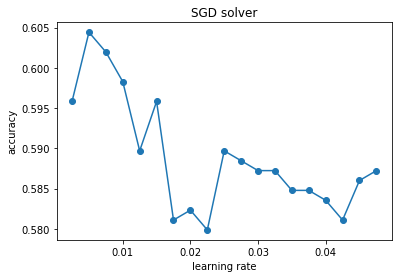

In [ ]:
score = []
time = []
for i in range(5, 100, 5):
  clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(400,),learning_rate_init= i/1000,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/2000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/2000)
plt.plot(time, score, 'o-')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()


learning rate is:  0.001
score:  0.6684118673647469
learning rate is:  0.002
score:  0.6701570680628273


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


learning rate is:  0.003
score:  0.6684118673647469


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


learning rate is:  0.004
score:  0.6701570680628273


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


learning rate is:  0.005
score:  0.6666666666666666


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


learning rate is:  0.006
score:  0.6649214659685864


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


learning rate is:  0.007
score:  0.6666666666666666
learning rate is:  0.008
score:  0.6719022687609075
learning rate is:  0.009
score:  0.6701570680628273
learning rate is:  0.01
score:  0.6719022687609075
learning rate is:  0.011
score:  0.6719022687609075
learning rate is:  0.012
score:  0.6474694589877836
learning rate is:  0.013
score:  0.6666666666666666
learning rate is:  0.014
score:  0.6666666666666666
learning rate is:  0.015
score:  0.6666666666666666
learning rate is:  0.016
score:  0.6684118673647469
learning rate is:  0.017
score:  0.6684118673647469
learning rate is:  0.018
score:  0.6771378708551483
learning rate is:  0.019
score:  0.6719022687609075


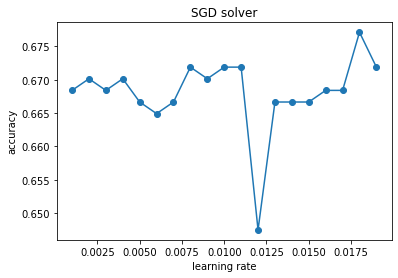

In [ ]:
score = []
time = []
for i in range(10, 200, 10):
  clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(400,),learning_rate_init= i/10000,max_iter=500, random_state=1)
  clf.fit(A, pd.to_numeric(b))
  print('learning rate is: ', i/10000)
  score_t = clf.score(A2, pd.to_numeric(b2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/10000)
plt.plot(time, score, 'o-')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()



In [ ]:

clf = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(400,),max_iter=500, random_state=1)
clf.fit(A, pd.to_numeric(b))
score_t = clf.score(A2, pd.to_numeric(b2))
print('score: ',score_t)

score:  0.6684118673647469


In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=0.001, hidden_layer_sizes=(400,),max_iter=500, random_state=1)
clf.fit(A, pd.to_numeric(b))
score_t = clf.score(A2, pd.to_numeric(b2))
print('score: ',score_t)

score:  0.6614310645724258


learning rate is:  0.001
score:  0.6068796068796068
learning rate is:  0.002
score:  0.6044226044226044
learning rate is:  0.003
score:  0.601965601965602
learning rate is:  0.004
score:  0.5995085995085995
learning rate is:  0.005
score:  0.6031941031941032
learning rate is:  0.006
score:  0.6007371007371007
learning rate is:  0.007
score:  0.601965601965602
learning rate is:  0.008
score:  0.601965601965602
learning rate is:  0.009
score:  0.601965601965602
learning rate is:  0.01
score:  0.5847665847665847
learning rate is:  0.011
score:  0.6007371007371007
learning rate is:  0.012
score:  0.6031941031941032
learning rate is:  0.013
score:  0.6068796068796068
learning rate is:  0.014
score:  0.6093366093366094


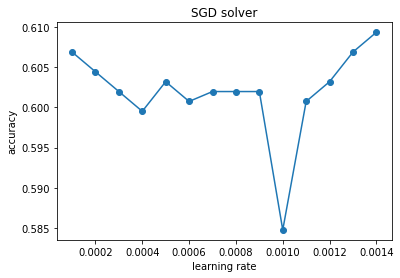

In [ ]:
score = []
time = []
for i in range(1, 15, 1):
  clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(400,),learning_rate_init= i/10000,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/1000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/10000)
plt.plot(time, score, 'o-')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

learning rate is:  0.015
score:  0.6068796068796068
learning rate is:  0.016
score:  0.6068796068796068
learning rate is:  0.017
score:  0.6105651105651105
learning rate is:  0.018
score:  0.6117936117936118
learning rate is:  0.019
score:  0.6130221130221131
learning rate is:  0.02
score:  0.6093366093366094
learning rate is:  0.021
score:  0.6093366093366094
learning rate is:  0.022
score:  0.6093366093366094
learning rate is:  0.023
score:  0.6117936117936118
learning rate is:  0.024
score:  0.6117936117936118
learning rate is:  0.025
score:  0.6142506142506142
learning rate is:  0.026
score:  0.6117936117936118
learning rate is:  0.027
score:  0.6117936117936118
learning rate is:  0.028
score:  0.6031941031941032
learning rate is:  0.029
score:  0.601965601965602


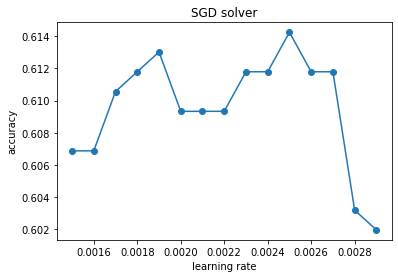

In [ ]:
score = []
time = []
for i in range(15, 30, 1):
  clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(400,),learning_rate_init= i/10000,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/10000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/10000)
plt.plot(time, score, 'o-')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

learning rate is:  0.1
score:  0.6044226044226044
learning rate is:  0.11
score:  0.6068796068796068
learning rate is:  0.12
score:  0.6191646191646192
learning rate is:  0.13
score:  0.6044226044226044
learning rate is:  0.14
score:  0.6093366093366094
learning rate is:  0.15
score:  0.6081081081081081
learning rate is:  0.16
score:  0.6031941031941032
learning rate is:  0.17
score:  0.6056511056511057
learning rate is:  0.18
score:  0.6191646191646192
learning rate is:  0.19
score:  0.6167076167076168


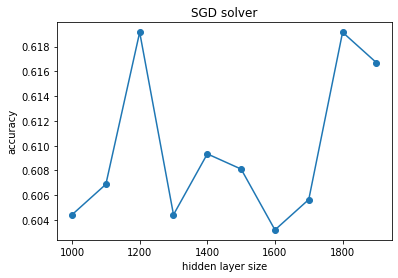

In [ ]:
score = []
time = []
for i in range(1000, 2000, 100):
  clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(i,),learning_rate_init= 0.0025,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/10000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i)
plt.plot(time, score, 'o-')
plt.xlabel('hidden layer size')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

learning rate is:  0.1
score:  0.675392670157068
learning rate is:  0.11
score:  0.6684118673647469
learning rate is:  0.12
score:  0.6684118673647469
learning rate is:  0.13
score:  0.6719022687609075
learning rate is:  0.14
score:  0.6736474694589878
learning rate is:  0.15
score:  0.6666666666666666
learning rate is:  0.16
score:  0.675392670157068
learning rate is:  0.17
score:  0.6736474694589878
learning rate is:  0.18
score:  0.6736474694589878
learning rate is:  0.19
score:  0.6596858638743456


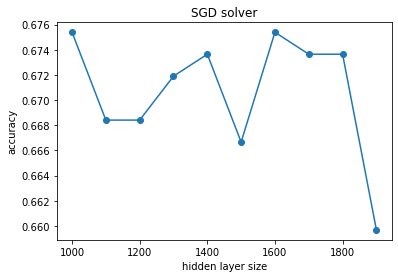

In [ ]:
score = []
time = []
for i in range(1000, 2000, 100):
  clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(i,),learning_rate_init= 0.01,max_iter=500, random_state=1)
  clf.fit(A, pd.to_numeric(b))
  print('learning rate is: ', i/10000)
  score_t = clf.score(A2, pd.to_numeric(b2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i)
plt.plot(time, score, 'o-')
plt.xlabel('hidden layer size')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(1000,),learning_rate_init= 0.01,max_iter=500, random_state=1)
clf.fit(A, pd.to_numeric(b))
clf.score(A2, pd.to_numeric(b2))
mean_squared_error(b2, clf.predict(A2),squared = False)


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


3.064176847975962

In [ ]:
clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(1000,),learning_rate_init= 0.001,max_iter=500, random_state=1)
clf.fit(A, pd.to_numeric(b))
clf.score(A2, pd.to_numeric(b2))
mean_squared_error(b2, clf.predict(A2),squared = False)


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


3.0263531293497965

In [ ]:
clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(1000,),learning_rate_init= 0.001,max_iter=500, random_state=1)
model = clf.fit(A, pd.to_numeric(b))
score = model.score(A2, pd.to_numeric(b2))
print(score)
mean_squared_error(b2, clf.predict(A2),squared = False)

0.6649214659685864


0.5788596842339373

In [ ]:
clf.score(A2, pd.to_numeric(b2))

0.6649214659685864

learning rate is:  0.0005
score:  0.6044226044226044
learning rate is:  0.001
score:  0.6044226044226044
learning rate is:  0.0015
score:  0.6044226044226044
learning rate is:  0.002
score:  0.6081081081081081
learning rate is:  0.0025
score:  0.6081081081081081
learning rate is:  0.003
score:  0.6081081081081081
learning rate is:  0.0035
score:  0.6081081081081081
learning rate is:  0.004
score:  0.6081081081081081
learning rate is:  0.0045
score:  0.6081081081081081
learning rate is:  0.005
score:  0.6081081081081081
learning rate is:  0.0055
score:  0.6081081081081081
learning rate is:  0.006
score:  0.6081081081081081
learning rate is:  0.0065
score:  0.6081081081081081
learning rate is:  0.007
score:  0.6093366093366094
learning rate is:  0.0075
score:  0.6081081081081081
learning rate is:  0.008
score:  0.6081081081081081
learning rate is:  0.0085
score:  0.6081081081081081
learning rate is:  0.009
score:  0.6081081081081081
learning rate is:  0.0095
score:  0.6093366093366094


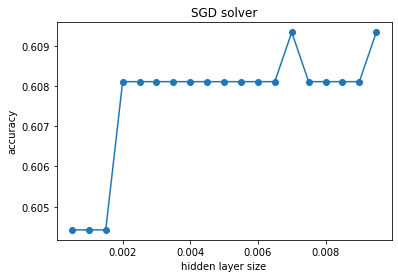

In [ ]:
score = []
time = []
for i in range(5, 100, 5):
  clf = MLPClassifier(solver='sgd', alpha=i/10000, hidden_layer_sizes=(1000,),learning_rate_init= 0.0025,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/10000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/10000)
plt.plot(time, score, 'o-')
plt.xlabel('hidden layer size')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

learning rate is:  0.0005
score:  0.597051597051597
learning rate is:  0.001
score:  0.5945945945945946
learning rate is:  0.0015
score:  0.5995085995085995
learning rate is:  0.002
score:  0.597051597051597
learning rate is:  0.0025
score:  0.597051597051597
learning rate is:  0.003
score:  0.5982800982800983
learning rate is:  0.0035
score:  0.5945945945945946
learning rate is:  0.004
score:  0.6044226044226044
learning rate is:  0.0045
score:  0.6007371007371007
learning rate is:  0.005
score:  0.5995085995085995
learning rate is:  0.0055
score:  0.5982800982800983
learning rate is:  0.006
score:  0.601965601965602
learning rate is:  0.0065
score:  0.5933660933660934
learning rate is:  0.007
score:  0.597051597051597
learning rate is:  0.0075
score:  0.597051597051597
learning rate is:  0.008
score:  0.5982800982800983
learning rate is:  0.0085
score:  0.5995085995085995
learning rate is:  0.009
score:  0.597051597051597
learning rate is:  0.0095
score:  0.5995085995085995


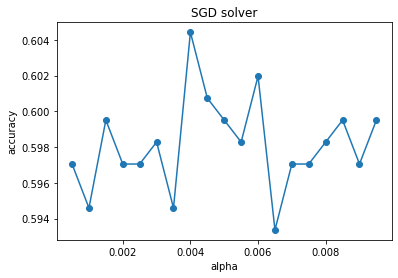

In [ ]:
score = []
time = []
for i in range(5, 100, 5):
  clf = MLPClassifier(solver='lbfgs', alpha=i/10000, hidden_layer_sizes=(1000,),learning_rate_init= 0.0025,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/10000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/10000)
plt.plot(time, score, 'o-')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

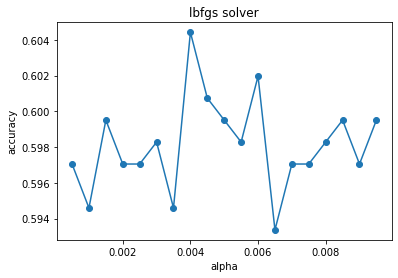

In [ ]:
plt.plot(time, score, 'o-')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('lbfgs solver')
plt.show()

learning rate is:  5e-05
score:  0.5847665847665847
learning rate is:  0.0001
score:  0.5737100737100738
learning rate is:  0.00015
score:  0.5921375921375921
learning rate is:  0.0002
score:  0.5798525798525799
learning rate is:  0.00025
score:  0.585995085995086
learning rate is:  0.0003
score:  0.5909090909090909
learning rate is:  0.00035
score:  0.5798525798525799
learning rate is:  0.0004
score:  0.5749385749385749
learning rate is:  0.00045
score:  0.5773955773955773
learning rate is:  0.0005
score:  0.5700245700245701
learning rate is:  0.00055
score:  0.5896805896805897
learning rate is:  0.0006
score:  0.5872235872235873
learning rate is:  0.00065
score:  0.5761670761670762
learning rate is:  0.0007
score:  0.5933660933660934
learning rate is:  0.00075
score:  0.5847665847665847
learning rate is:  0.0008
score:  0.5921375921375921
learning rate is:  0.00085
score:  0.5786240786240786
learning rate is:  0.0009
score:  0.5773955773955773
learning rate is:  0.00095
score:  0.592

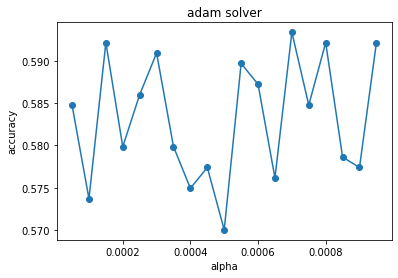

In [ ]:
score = []
time = []
for i in range(5, 100, 5):
  clf = MLPClassifier(solver='adam', alpha=i/100000, hidden_layer_sizes=(1000,),learning_rate_init= 0.0025,max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/100000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/100000)
plt.plot(time, score, 'o-')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('adam solver')
plt.show()

#Tree

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)

clf.score(X2,y2)
prediction = clf.predict(X2)

In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(X, y)

  clf.score(X2,y2)
  prediction = clf.predict(X2)
  newscore = []
  for things in prediction:
    if things> 0.5:
      things = 1
    else:
      things = 0
    newscore.append(things)
  correct = 0
  i = 0
  for things in y2:
    if things == newscore[i]:
      correct += 1
    i += 1
  correct = correct/len(newscore)
  print('correctness:',correct)

correctness: 0.5663390663390664
correctness: 0.5651105651105651
correctness: 0.5823095823095823
correctness: 0.5773955773955773
correctness: 0.5884520884520884
correctness: 0.5786240786240786
correctness: 0.5724815724815725
correctness: 0.5700245700245701
correctness: 0.5651105651105651
correctness: 0.5896805896805897
correctness: 0.5958230958230958
correctness: 0.5896805896805897
correctness: 0.5896805896805897
correctness: 0.5945945945945946
correctness: 0.5872235872235873
correctness: 0.5896805896805897
correctness: 0.5872235872235873
correctness: 0.5896805896805897
correctness: 0.5933660933660934
correctness: 0.5933660933660934
correctness: 0.5933660933660934
correctness: 0.5933660933660934
correctness: 0.5933660933660934
correctness: 0.5933660933660934
correctness: 0.5945945945945946
correctness: 0.5933660933660934
correctness: 0.5933660933660934
correctness: 0.5945945945945946
correctness: 0.5921375921375921


In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(A, b)

  prediction = clf.predict(X2)

  score = clf.score(A2, pd.to_numeric(b2))
  rmse = mean_squared_error(b2, clf.predict(A2),squared = False)
  print('score:' , score)
  print('rmse:', rmse/2)

score: 0.03509079761337075
rmse: 1.1519282125828247
score: 0.051116706442910886
rmse: 1.1423221315938534
score: 0.05727696515251979
rmse: 1.1386080508501881
score: 0.08912270156044766
rmse: 1.119211412647346
score: 0.08349599277837527
rmse: 1.122662910098954
score: 0.060939368445695474
rmse: 1.136394198172101
score: 0.0343201950565607
rmse: 1.1523881012766757
score: 0.035676062014958654
rmse: 1.151578809324728
score: 0.022732368171159867
rmse: 1.1592816142408569
score: 0.017698003921500893
rmse: 1.1622637803904423
score: 0.03851764048455797
rmse: 1.1498808758777916
score: 0.00462110912510183
rmse: 1.1699745209035686
score: 0.0021048011620593554
rmse: 1.1714524294505713
score: -0.02496203211154624
rmse: 1.1872333286101837
score: -0.04116161473431834
rmse: 1.1965786921733896
score: -0.03723899307460288
rmse: 1.1943224839486313
score: -0.028713352279132964
rmse: 1.1894039576413407
score: -0.035576534839673934
rmse: 1.1933649864572984
score: -0.03214815831556983
rmse: 1.1913879735817168
sc

In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(A, b)

  clf.score(A2,b2)
  prediction = clf.predict(A2)
  newscore = []
  for things in prediction:
    if things> 0.5:
      things = 1
    else:
      things = 0
    newscore.append(things)
  correct = 0
  i = 0
  for things in b2:
    if things == newscore[i]:
      correct += 1
    i += 1
  correct = correct/len(newscore)
  print('correctness:',correct)

correctness: 0.6212914485165794
correctness: 0.643979057591623
correctness: 0.6527050610820244
correctness: 0.6544502617801047
correctness: 0.6579406631762653
correctness: 0.6649214659685864
correctness: 0.6579406631762653
correctness: 0.6544502617801047
correctness: 0.643979057591623
correctness: 0.6631762652705061
correctness: 0.6527050610820244
correctness: 0.6527050610820244
correctness: 0.6457242582897034
correctness: 0.643979057591623
correctness: 0.643979057591623
correctness: 0.6404886561954625
correctness: 0.643979057591623
correctness: 0.6457242582897034
correctness: 0.6457242582897034
correctness: 0.643979057591623
correctness: 0.6422338568935427
correctness: 0.6422338568935427
correctness: 0.6422338568935427
correctness: 0.6422338568935427
correctness: 0.643979057591623
correctness: 0.643979057591623
correctness: 0.6422338568935427
correctness: 0.6422338568935427
correctness: 0.643979057591623


In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(X, y)

  clf.score(X2,y2)
  prediction = clf.predict(X2)
  newscore = []
  for things in prediction:
    if things> 0.5:
      things = 1
    else:
      things = 0
    newscore.append(things)
  correct = 0
  i = 0
  for things in y2:
    if things == newscore[i]:
      correct += 1
    i += 1
  correct = correct/len(newscore)
  print('correctness:',correct)
  print('score:' ,clf.score(X2,y2))

correctness: 0.5663390663390664
score: 0.5663390663390664
correctness: 0.5651105651105651
score: 0.5651105651105651
correctness: 0.5823095823095823
score: 0.5823095823095823
correctness: 0.5773955773955773
score: 0.5773955773955773
correctness: 0.5884520884520884
score: 0.5884520884520884
correctness: 0.5786240786240786
score: 0.5786240786240786
correctness: 0.5737100737100738
score: 0.5737100737100738
correctness: 0.5687960687960688
score: 0.5687960687960688
correctness: 0.5626535626535627
score: 0.5626535626535627
correctness: 0.5921375921375921
score: 0.5921375921375921
correctness: 0.5958230958230958
score: 0.5958230958230958
correctness: 0.5872235872235873
score: 0.5872235872235873
correctness: 0.5909090909090909
score: 0.5909090909090909
correctness: 0.5933660933660934
score: 0.5933660933660934
correctness: 0.5884520884520884
score: 0.5884520884520884
correctness: 0.5909090909090909
score: 0.5909090909090909
correctness: 0.5872235872235873
score: 0.5872235872235873
correctness: 0

In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(A, b)

  clf.score(A2,b2)
  prediction = clf.predict(A2)
  newscore = []
  for things in prediction:
    if things> 0.5:
      things = 1
    else:
      things = 0
    newscore.append(things)
  correct = 0
  i = 0
  for things in b2:
    if things == newscore[i]:
      correct += 1
    i += 1
  correct = correct/len(newscore)
  print('correctness:',correct)
  print('score:' ,clf.score(A2,b2))

correctness: 0.6212914485165794
score: 0.6212914485165794
correctness: 0.643979057591623
score: 0.643979057591623
correctness: 0.6527050610820244
score: 0.6527050610820244
correctness: 0.6544502617801047
score: 0.6544502617801047
correctness: 0.6579406631762653
score: 0.6579406631762653
correctness: 0.6649214659685864
score: 0.6649214659685864
correctness: 0.6579406631762653
score: 0.6579406631762653
correctness: 0.6544502617801047
score: 0.6544502617801047
correctness: 0.643979057591623
score: 0.643979057591623
correctness: 0.6631762652705061
score: 0.6631762652705061
correctness: 0.6527050610820244
score: 0.6527050610820244
correctness: 0.6527050610820244
score: 0.6527050610820244
correctness: 0.6457242582897034
score: 0.6457242582897034
correctness: 0.6422338568935427
score: 0.6422338568935427
correctness: 0.643979057591623
score: 0.643979057591623
correctness: 0.6404886561954625
score: 0.6404886561954625
correctness: 0.6422338568935427
score: 0.6422338568935427
correctness: 0.64572

In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(A, b)

  clf.score(A2,b2)
  prediction = clf.predict(A2)

  score = clf.score(A2, pd.to_numeric(b2))
  rmse = mean_squared_error(b2, clf.predict(A2),squared = False)
  print('score:' , score)
  print('rmse:', rmse/2)

score: 0.193717277486911
rmse: 1.519793776770141
score: 0.193717277486911
rmse: 1.6199831942764775
score: 0.18848167539267016
rmse: 1.5948761762130648
score: 0.19546247818499127
rmse: 1.591452956605694
score: 0.2006980802792321
rmse: 1.5482354984992637
score: 0.13787085514834205
rmse: 1.7980501364516277
score: 0.1762652705061082
rmse: 1.7213118500625604
score: 0.16928446771378708
rmse: 1.6387274252208723
score: 0.16753926701570682
rmse: 1.6572596654127076
score: 0.18150087260034903
rmse: 1.6162082615961528
score: 0.18848167539267016
rmse: 1.57297752358491
score: 0.19720767888307156
rmse: 1.539616461384958
score: 0.19022687609075042
rmse: 1.6041503761553566
score: 0.1849912739965096
rmse: 1.5885717514245568
score: 0.18150087260034903
rmse: 1.568533290726937
score: 0.1849912739965096
rmse: 1.5671418832937472
score: 0.1849912739965096
rmse: 1.59391841580125
score: 0.1849912739965096
rmse: 1.593233948721206
score: 0.17801047120418848
rmse: 1.5924121998749714
score: 0.17801047120418848
rmse

In [ ]:
for i in range(1,30):
  clf = tree.DecisionTreeClassifier(max_depth=i)
  clf = clf.fit(A, b)

  clf.score(A2,b2)
  prediction = clf.predict(A2)

  score = clf.score(A2, pd.to_numeric(b2))
  rmse = mean_squared_error(b2, clf.predict(A2),squared = False)
  print('score:' , score)
  print('rmse:', rmse/2)

score: 0.6212914485165794
rmse: 0.3076965028576944
score: 0.643979057591623
rmse: 0.2983374525635262
score: 0.6527050610820244
rmse: 0.29465867496052767
score: 0.6544502617801047
rmse: 0.29391739410074696
score: 0.6579406631762653
rmse: 0.2924291952010498
score: 0.6649214659685864
rmse: 0.28942984211696865
score: 0.6579406631762653
rmse: 0.2924291952010498
score: 0.6544502617801047
rmse: 0.29391739410074696
score: 0.643979057591623
rmse: 0.2983374525635262
score: 0.6631762652705061
rmse: 0.2901825868007477
score: 0.6527050610820244
rmse: 0.29465867496052767
score: 0.6527050610820244
rmse: 0.29465867496052767
score: 0.6457242582897034
rmse: 0.29760533501194864
score: 0.643979057591623
rmse: 0.2983374525635262
score: 0.6422338568935427
rmse: 0.29906777789761024
score: 0.6404886561954625
rmse: 0.29979632411211177
score: 0.643979057591623
rmse: 0.2983374525635262
score: 0.6457242582897034
rmse: 0.29760533501194864
score: 0.643979057591623
rmse: 0.2983374525635262
score: 0.643979057591623
r

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(A,b)
gnb.score(A2,b2)
score = gnb.score(A2, pd.to_numeric(b2))
rmse = mean_squared_error(b2, gnb.predict(A2),squared = False)
print('score:' , score)
print('rmse:', rmse/2)

score: 0.06108202443280977
rmse: 2.2745653363794562


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(A,b)
gnb.score(A2,b2)
score = gnb.score(A2, pd.to_numeric(b2))
rmse = mean_squared_error(b2, gnb.predict(A2),squared = False)
print('score:' , score)
print('rmse:', rmse/2)

score: 0.6544502617801047
rmse: 0.29391739410074696


In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
clf.fit(A,b)
clf.score(A2,b2)
score = clf.score(A2, pd.to_numeric(b2))
rmse = mean_squared_error(b2, clf.predict(A2),squared = False)
print('score:' , score)
print('rmse:', rmse/2)

score: 0.6457242582897034
rmse: 0.29760533501194864


In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
clf.fit(X,y)
clf.score(X2,y2)
score = clf.score(X2, pd.to_numeric(y2))
rmse = mean_squared_error(y2, clf.predict(X2),squared = False)
print('score:' , score)
print('rmse:', rmse/2)

score: 0.5823095823095823
rmse: 0.3231448660006908


In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(A,b)
clf.score(A2,b2)
score = clf.score(A2, pd.to_numeric(b2))
rmse = mean_squared_error(b2, clf.predict(A2),squared = False)
print('score:' , score)
print('rmse:', rmse/2)

score: 0.6457242582897034
rmse: 0.29760533501194864


In [ ]:
score = []
time = []
for i in range(5, 100, 5):
  clf = MLPClassifier(solver='lbfgs', alpha=i/10000, hidden_layer_sizes=(1000,),max_iter=500, random_state=1)
  clf.fit(X, pd.to_numeric(y))
  print('learning rate is: ', i/10000)
  score_t = clf.score(X2, pd.to_numeric(y2))
  print('score: ',score_t)
  score.append(score_t)
  time.append(i/10000)
plt.plot(time, score, 'o-')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('SGD solver')
plt.show()

In [ ]:
print(y)
print(sum(y))
print(y2.values)
print(sum(y2))

0       0
1       0
2       1
3       0
4       0
       ..
3595    1
3596    0
3597    0
3598    1
3599    0
Name: score, Length: 3600, dtype: int64
1911
[0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1
 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1
 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0
 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0
 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0
 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0
 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1
 0 1 1 1 0 1 1 1 1 1

In [ ]:
clf.predict(X2)

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,